In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from time import time
from itertools import cycle

G = 6.67430e-11  # gravitational constant
AU = 1.496e+11 # astronomical unit, m
SM = 1.989e30 # solar mass, kg
EM = 5.972e24 # earth mass, kg

# Class Definitions

In [2]:
# Represents a body in space
class Body:
    def __init__(self, position, mass, velocity=None, name=""):
        self.name = name
        self.mass = mass
        self.position = np.array(position)
        if velocity is None:
            self.velocity = np.array([0.0, 0.0, 0.0])
        else:
            self.velocity = np.array(velocity)
            
    def __str__(self):  # for debugging
        x, y, z = self.position
        vx, vy, vz = self.velocity if self.velocity is not None else (0,0,0)
        data = f"m = {self.mass}\t x = ({x}, {y}, {z})\t v = ({vx}, {vy}, {vz})"
        if len(self.name) > 0:
            data = f"{self.name}: {data}"
        return data

### Force Calculators

In [3]:
# Force calculator class with two children: brute force and Barnes-Hut
class ForceCalculator:
    def compute_accelerations(self, positions, masses):
        pass
    
# Naively compute all O(n^2) force pairs
class DirectForceCalculator(ForceCalculator):
    def compute_accelerations(positions, masses):
        N = len(positions)
        accelerations = np.zeros((N, 3))

        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                r = positions[j] - positions[i]
                a = (G * masses[j] / np.linalg.norm(r)**3) * r
                accelerations[i] += a
        return accelerations

In [4]:
# Direction Enum
class OctDir(Enum):
    LNW = 0  # lower northwest
    LNE = 1
    LSW = 2
    LSE = 3
    UNW = 4
    UNE = 5
    USW = 6
    USE = 7
    
    def to_dx(self):
        dx = 1 if self.value % 2 == 1 else 0
        dy = 1 if (self.value % 4) < 2 else 0
        dz = 1 if self.value >= 4 else 0
        return np.array([dx, dy, dz])

# Stores data for a single octant or suboctant
class Octant:
    def __init__(self, endpoint, length):
        self.endpoint = endpoint  # lower bottom left point
        self.length = length
        
    def __str__(self):  # for debugging
        x,y,z = self.endpoint
        l = self.length
        return f"Octant of length {l} at ({x}, {y}, {z})"

    # Test if the vector x is contained within this octant
    def contains(self, x):
        dx = x - self.endpoint
        return ((dx >= 0) & (dx <= self.length)).all()
    
    # Returns a octant object for the given sub-octant enum
    def subOct(self, subOct):
        newLen = self.length / 2
        newEnd = self.endpoint + subOct.to_dx() * newLen
        return Octant(newEnd, newLen)

# The Barnes-Hut Tree
class BHNode():
    def __init__(self, octant):
        self.body = None  # is either a single body or a center of mass
        self.children = None
        self.octant = octant
      
    # for debugging: return total nonempty nodes (octants)
    def count(self):
        if self.body is None:
            return 0
        print(str(self.body))
        if self.children is None:
            return 1
        
        tot = 1
        for child in self.children:
            tot += child.count()
        return tot
    
    # Test if this body is in the given octant
    def contains_point(self, x):
        return self.octant.contains(x)
    
    # Add a child node
    def insert(self, position, mass):
        b = Body(position, mass)
        if self.children is None:  # Leaf node
            if self.body is None:  # Empty octant: just add body
                self.body = b
                return
            
            # Add 8 sub-octants as children
            self.children = []
            for octant in OctDir:
                sub_octant = self.octant.subOct(octant)
                self.children.append(BHNode(sub_octant))
                
            # Add existing body to correct suboctant
            for child in self.children:
                if child.contains_point(self.body.position):
                    child.insert(self.body.position, self.body.mass)
                    break
        
        # Aggregate bodies
        totMass = self.body.mass + b.mass;
        CoM = (self.body.mass * self.body.position + b.mass * b.position) / totMass
        self.body.mass = totMass
        self.body.position = CoM

        # Insert into appropriate child node
        for child in self.children:
            if child.contains_point(position):
                child.insert(position, mass)
                break
    
    # Compute the total force experienced by a body with the given position and mass
    def compute_force(self, position, mass, theta):
        if self.body is None:  # empty octant
            return 0
        
        s = self.octant.length
        r = self.body.position - position
        d = np.linalg.norm(r)
        if self.children is None and d < 1e-6:  # no self-interaction
            return 0

        # Direct computation or aggregate computation
        d = max(1e-6, d)
        if self.children is None or s/d < theta: 
            return (G * mass * self.body.mass / d**3) * r

        # Recur downwards
        force = 0
        for child in self.children:
            force += child.compute_force(position, mass, theta)
        return force

# Compute forces by constructing the Barnes-Hut tree
class BarnesHutForceCalculator(ForceCalculator):
    def compute_accelerations(positions, masses, theta=0.5):
        N = len(positions)
        
        # Build root octant (i.e. the largest one)
        mins = np.min(positions, axis=0)
        maxes = np.max(positions, axis=0)
        length = max(maxes - mins)
        
        # Apply some padding to avoid weird floating point/boundary issues
        pad = length * 1e-6
        octant = Octant(mins - pad/2, length + pad)
        
        # Construct octree
        root = BHNode(octant)
        for i in range(N):
            root.insert(positions[i], masses[i])
        
        # Compute forces on each body
        accelerations = np.zeros((N, 3))
        for i in range(N):
            F = root.compute_force(positions[i], masses[i], theta)
            accelerations[i] = F / masses[i]
        return accelerations

### Integrators

In [5]:
# Integrator class with two children, RK4 and Leapfrog (symplectic)
class Integrator():
    def _derivatives(self, positions, vels):
        accs = self.force_calculator.compute_accelerations(positions, self.masses)
        return vels, accs

    def __init__(self, bodies, force_calculator):
        self.bodies = bodies
        self.masses = np.array([b.mass for b in bodies])
        self.force_calculator = force_calculator
        
    def get_state(self):
        positions = np.array([b.position for b in self.bodies])
        velocities = np.array([b.velocity for b in self.bodies])
        return positions, velocities

    def set_state(self, positions, velocities):
        for i, body in enumerate(self.bodies):
            body.position = positions[i]
            body.velocity = velocities[i]
            
# 4th order Runge-Kutta integrator
class RK4Integrator(Integrator):
    def step(self, dt):
        p0, v0 = self.get_state()
        
        k1v, k1a = self._derivatives(p0, v0)
        k2v, k2a = self._derivatives(p0 + 0.5 * dt * k1v, v0 + 0.5 * dt * k1a)
        k3v, k3a = self._derivatives(p0 + 0.5 * dt * k2v, v0 + 0.5 * dt * k2a)
        k4v, k4a = self._derivatives(p0 + dt * k3v, v0 + dt * k3a)

        new_pos = p0 + (dt/6)*(k1v + 2*k2v + 2*k3v + k4v)
        new_vel = v0 + (dt/6)*(k1a + 2*k2a + 2*k3a + k4a)
        self.set_state(new_pos, new_vel)

# Velocity-Verlet integrator
class LeapfrogIntegrator(Integrator):
    def __init__(self, bodies, force_calculator):
        self.bodies = bodies
        self.masses = np.array([b.mass for b in bodies])
        self.force_calculator = force_calculator
        
        # Special for leapfrog!
        self.prev_acc = np.zeros((len(bodies), 3))
    
    def step(self, dt):
        p0, v0 = self.get_state()
        
        a0 = self.prev_acc
        a1 = self._derivatives(p0, v0)[1]

        p1 = p0 + (v0 * dt) + 0.5 * (a0 * dt**2)
        v1 = v0 + 0.5 * (a0 + a1) * dt

        self.set_state(p1, v1)
        self.prev_acc = a1

### Simulation Setup

In [11]:
# Compute the total energy within a system of bodies
def compute_energy(bodies):
    KE = 0
    PE = 0
    for i, body in enumerate(bodies):
        KE += 0.5 * body.mass * (np.linalg.norm(body.velocity)**2)
        for j, body2 in enumerate(bodies):
            if i != j:
                # soften by an eps to avoid blowup
                eps = 1e-6
                rij = np.linalg.norm(body.position - body2.position)
                PE -= (G / 2) * (body.mass * body2.mass / np.sqrt(rij**2 + eps**2))
    return KE + PE

# Compute the total angular momentum within a system of bodies
def compute_angular_momentum(bodies):
    L = 0
    for i, body in enumerate(bodies):
        r = body.position
        p = body.mass * body.velocity
        L += np.linalg.norm(np.cross(r, p))

    return L

# Set up an instance of an N-body simulation
class NBodySimulation:
    def __init__(self, bodies, dt, steps, Integrator, ForceCalculator):
        self.integrator = Integrator(bodies, ForceCalculator)
        self.bodies = bodies
        self.dt = dt
        self.steps = steps
        self.pos_hist = np.zeros((steps, len(self.bodies), 3))
        self.energy_hist = np.zeros(steps)
        self.ang_mom_hist = np.zeros(steps)

    def run(self):
        for i in range(self.steps):  
            self.energy_hist[i] = compute_energy(self.bodies)
            self.ang_mom_hist[i] = compute_angular_momentum(self.bodies)
            
            self.integrator.step(self.dt)
            self.bodies = self.integrator.bodies
            
            for j, body in enumerate(self.bodies):
                self.pos_hist[i][j] = body.position

    def get_energy(self):
         return self.energy_hist

    def get_ang_mom(self):
        return self.ang_mom_hist

    def get_traj(self):
        return self.pos_hist

    def plot_energy(self, filename=None):
        t = np.arange(self.steps) * self.dt
        plt.plot(t, self.energy_hist)
        plt.xlabel("Time (s)")
        plt.ylabel("Total Energy (J)")
        plt.title("Energy vs Time")

        if filename is not None:
            plt.savefig(filename, dpi=300, bbox_inches="tight")
        
        plt.show()

    def plot_ang_mom(self, filename=None):
        t = np.arange(self.steps) * self.dt
        plt.plot(t, self.ang_mom_hist)
        plt.xlabel("Time (s)")
        plt.ylabel("Total Angular Momentum (kg m^2/s)")
        plt.title("Angular Momentum vs Time")
        
        if filename is not None:
            plt.savefig(filename, dpi=300, bbox_inches="tight")

        plt.show()

    def plot_traj(self, filename=None, x_size=10, y_size=10, labels=None, colors=None, legend=False, title=""):

        #helper function for getting axes bounds
        def set_3d_axes_equal(ax):

            x_limits = ax.get_xlim3d()  # type: ignore
            y_limits = ax.get_ylim3d()  # type: ignore
            z_limits = ax.get_zlim3d()  # type: ignore

            x_range = abs(x_limits[1] - x_limits[0])
            x_middle = np.mean(x_limits)
            y_range = abs(y_limits[1] - y_limits[0])
            y_middle = np.mean(y_limits)
            z_range = abs(z_limits[1] - z_limits[0])
            z_middle = np.mean(z_limits)

            plot_radius = 0.5 * max([x_range, y_range, z_range])

            ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])  # type: ignore
            ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])  # type: ignore
            ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])  # type: ignore

    
        n_bodies = self.pos_hist.shape[1]

        if labels is None:
            labels = [f"Body {i}" for i in range(n_bodies)]

        if colors is None:
            color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
            colors = [next(color_cycle) for _ in range(n_bodies)]

        fig = plt.figure(figsize=(x_size, y_size))
        ax = fig.add_subplot(111, projection="3d")
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")

        for i in range(n_bodies):
            traj = ax.plot(
                self.pos_hist[:, i, 0],
                self.pos_hist[:, i, 1],
                self.pos_hist[:, i, 2],
                color=colors[i],
            )

            # final position marker
            ax.scatter(
                self.pos_hist[-1, i, 0],
                self.pos_hist[-1, i, 1],
                self.pos_hist[-1, i, 2],
                marker="o",
                color=traj[0].get_color(),
                label=labels[i],
            )

        set_3d_axes_equal(ax)
        plt.title(title)

        if legend:
            ax.legend(loc="center right", bbox_to_anchor=(1.325, 0.5))
            fig.subplots_adjust(right=0.7)

        if filename is not None:
            plt.savefig(filename, dpi=300, bbox_inches="tight")

        plt.show()

# Numerical Experiments

In [8]:
# Convenience method to generate random bodies for testing
def generate_random_bodies(
    N,
    mass_range=(1e20, 1e26),
    position_scale=1e11,
    velocity_scale=1e3,
    seed=None,
):
    rng = np.random.default_rng(seed)
    bodies = []

    for i in range(N):
        position = position_scale * rng.uniform(-1, 1, size=3)
        velocity = velocity_scale * rng.uniform(-1, 1, size=3)
        mass = rng.uniform(*mass_range)

        bodies.append(
            Body(
                position=position,
                velocity=velocity,
                mass=mass,
                name=f"Body {i}",
            )
        )

    return bodies

### Simulation Validation

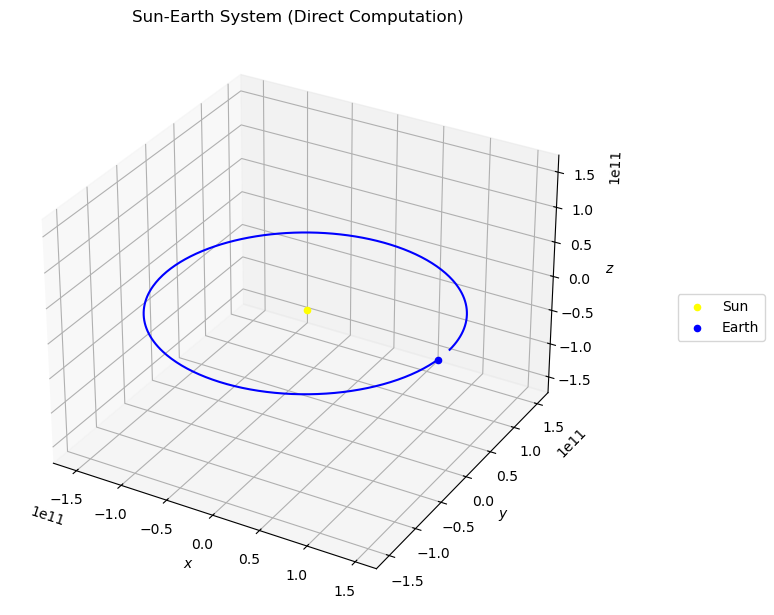

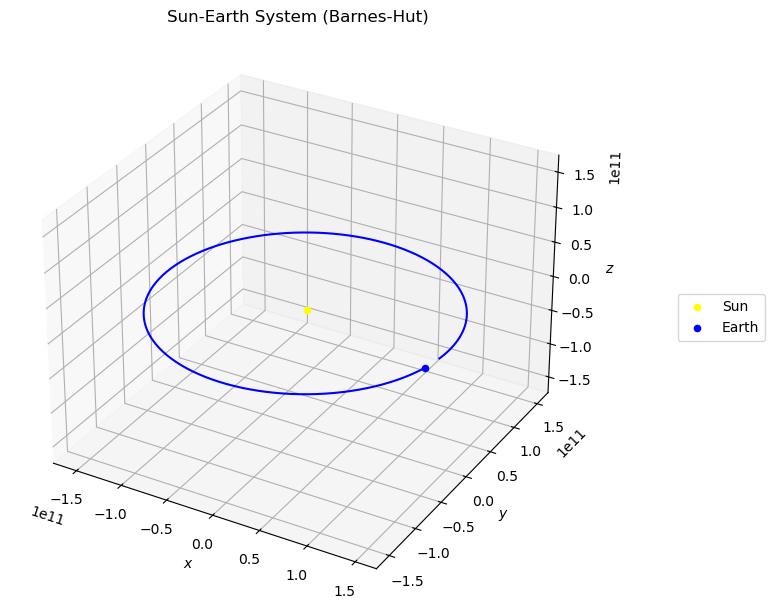

Relative Error: 0.12010912207240358


In [12]:
p1 = Body([0., 0., 0.], SM, [0., 0., 0.], "Sun")
p2 = Body([AU, 0., 0.], 5.972e24, [0., 30000., 0.], "Earth")

day = 60*60*24
body_names = ["Sun", "Earth"]
body_colors = ["Yellow", "Blue"]

sim1 = NBodySimulation([p1, p2], day, 366, RK4Integrator, DirectForceCalculator)
sim1.run()
sim1.plot_traj("Naive Sun-earth", 10, 10, body_names, body_colors, legend=True, title="Sun-Earth System (Direct Computation)")

sim2 = NBodySimulation([p1, p2], day, 366, RK4Integrator, BarnesHutForceCalculator)
sim2.run()
sim2.plot_traj("BH Sun-earth", 10, 10, body_names, body_colors, legend=True, title="Sun-Earth System (Barnes-Hut)")

traj1 = sim1.get_traj()
traj2 = sim2.get_traj()

tot_err = 0
for i in range(len(traj1)):
    rel_err = np.linalg.norm(traj1[i] - traj2[i]) / np.linalg.norm(traj1[i])
    tot_err += rel_err / len(traj1)
print("Relative Error:", tot_err) 

### Barnes-Hut Testing

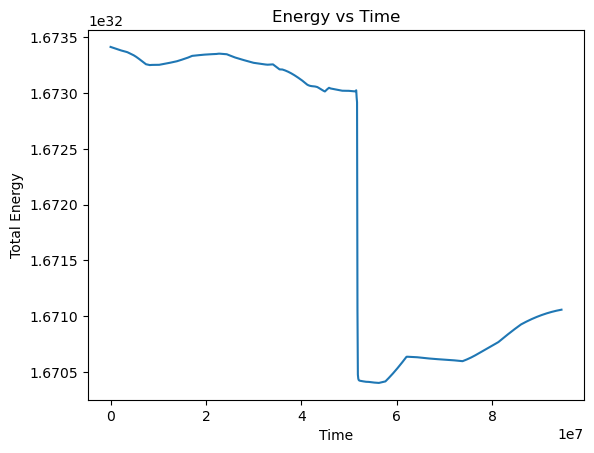

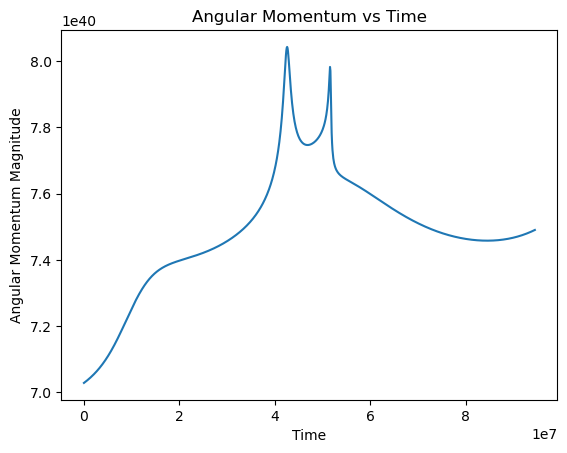

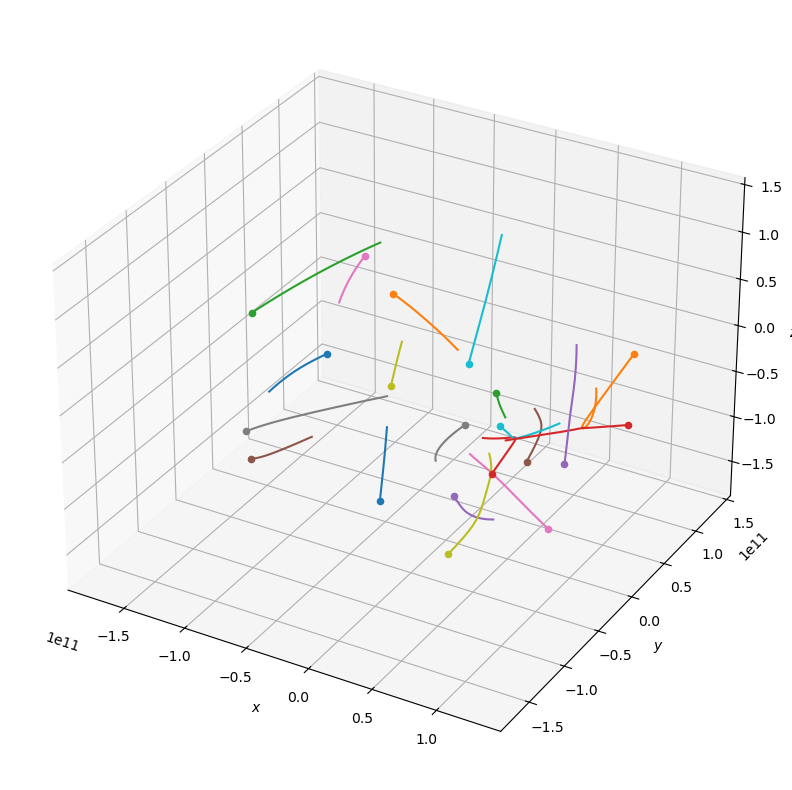

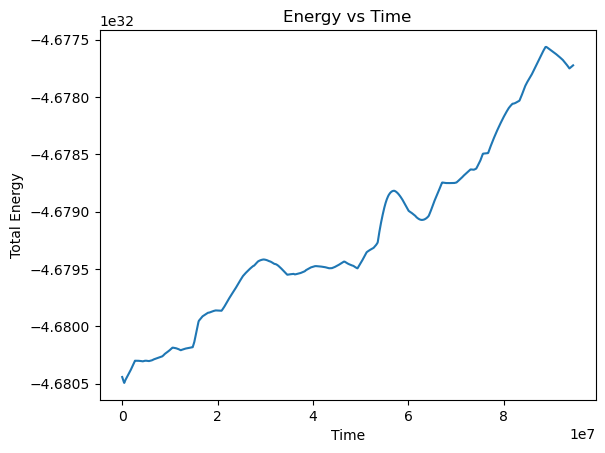

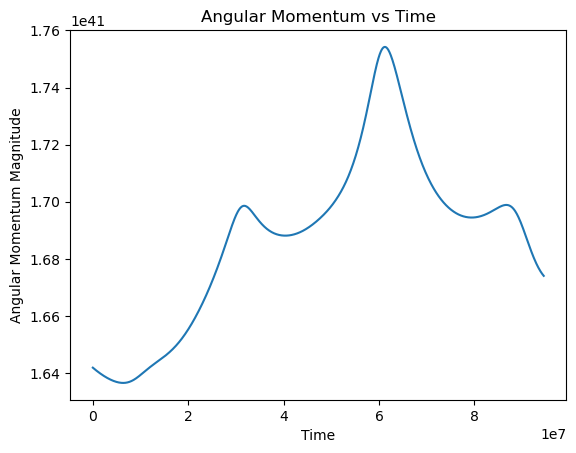

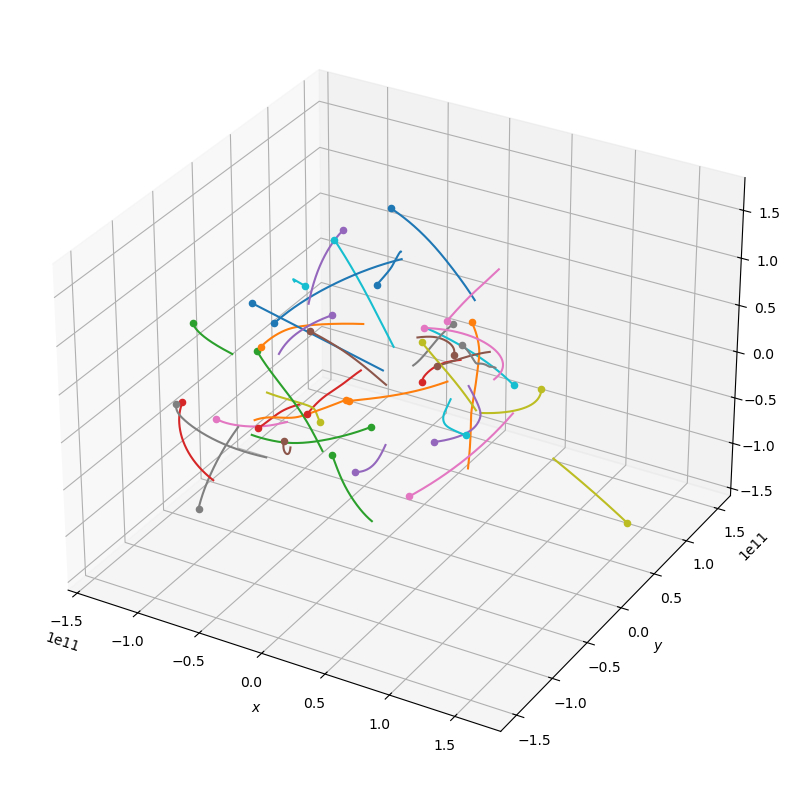

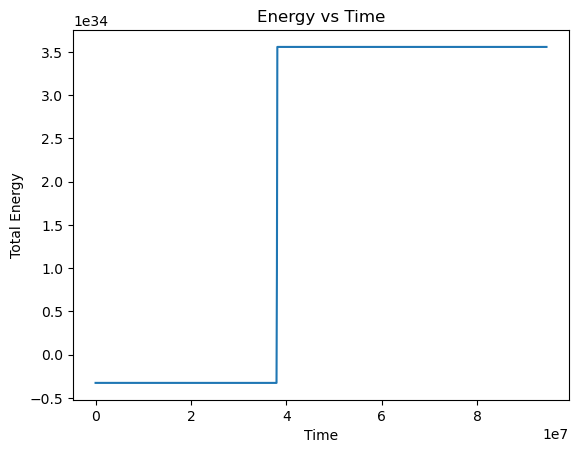

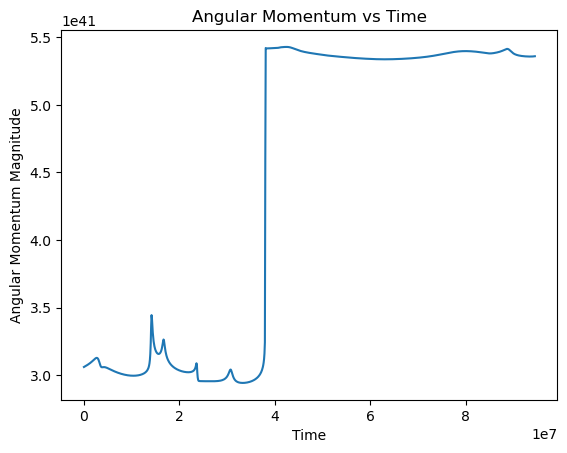

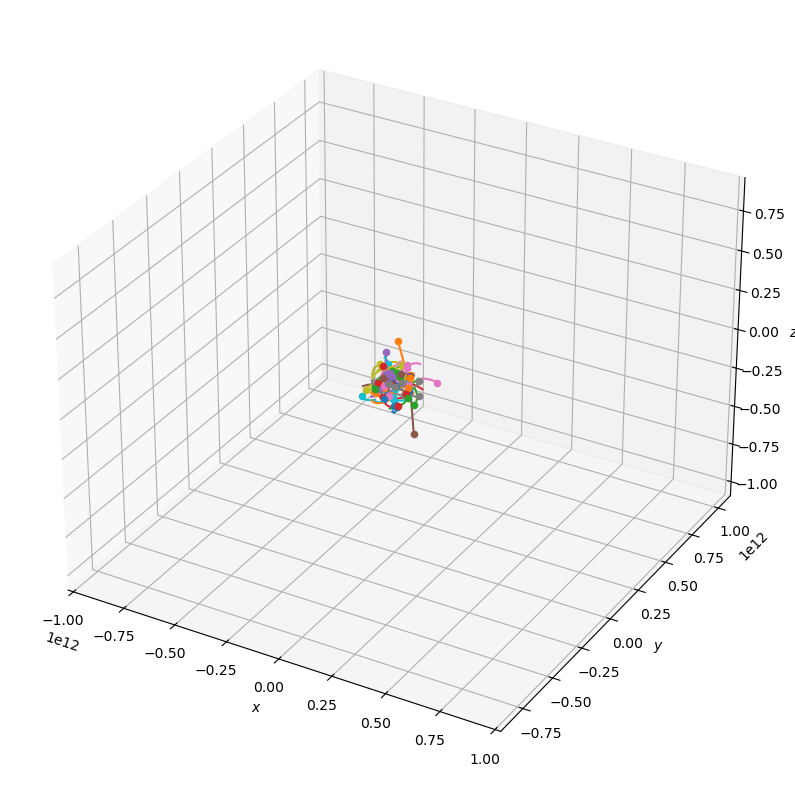

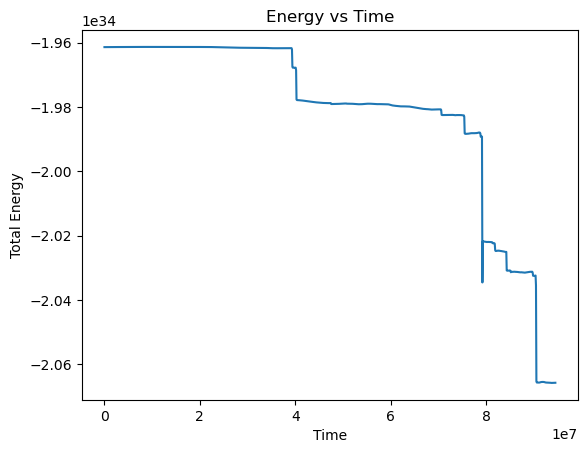

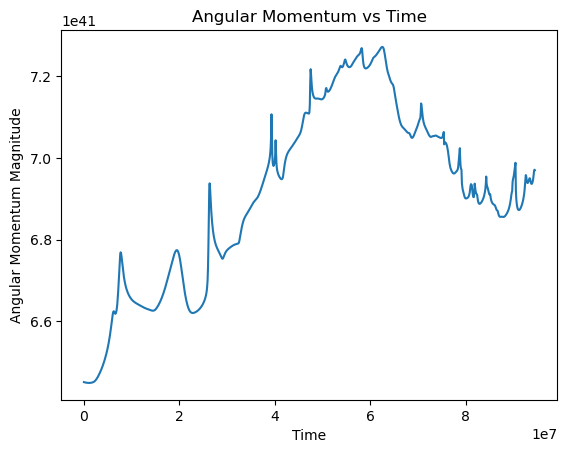

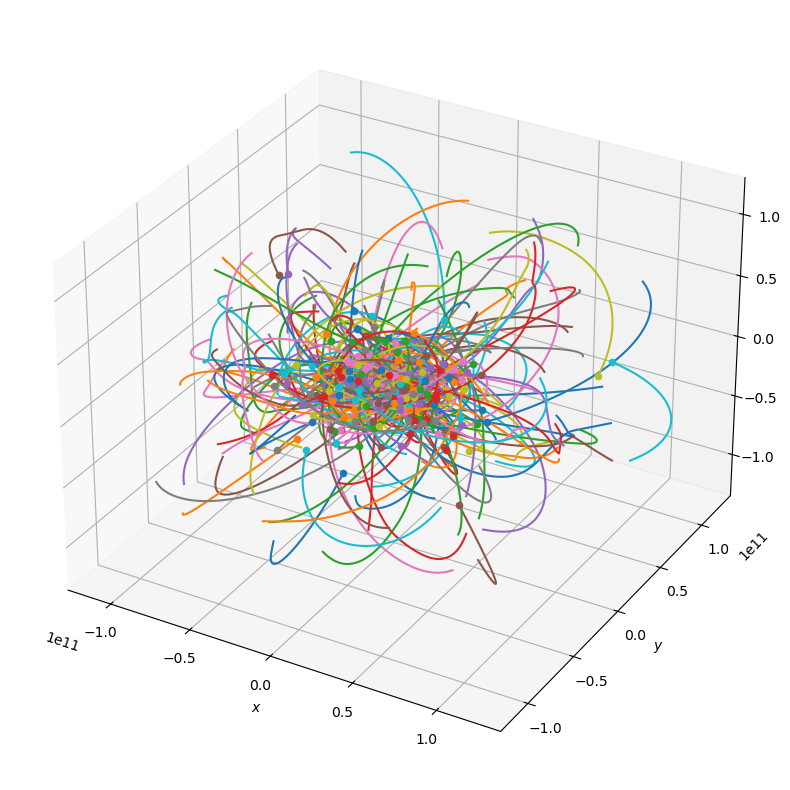

In [35]:
dt = 60*60*24
steps = 365*3

for n in [20,40,80,160]:
    bodies = generate_random_bodies(n, seed=n)

    sim = NBodySimulation(bodies, dt, steps, RK4Integrator, BarnesHutForceCalculator)
    sim.run()

    sim.plot_energy(filename=f"BHenergy_plot{n}")
    sim.plot_ang_mom(filename=f"BHang_plot{n}")
    sim.plot_traj(filename=f"BHtraj_plot{n}", title=f"Trajectory: {n} bodies")

### Runtime Analysis

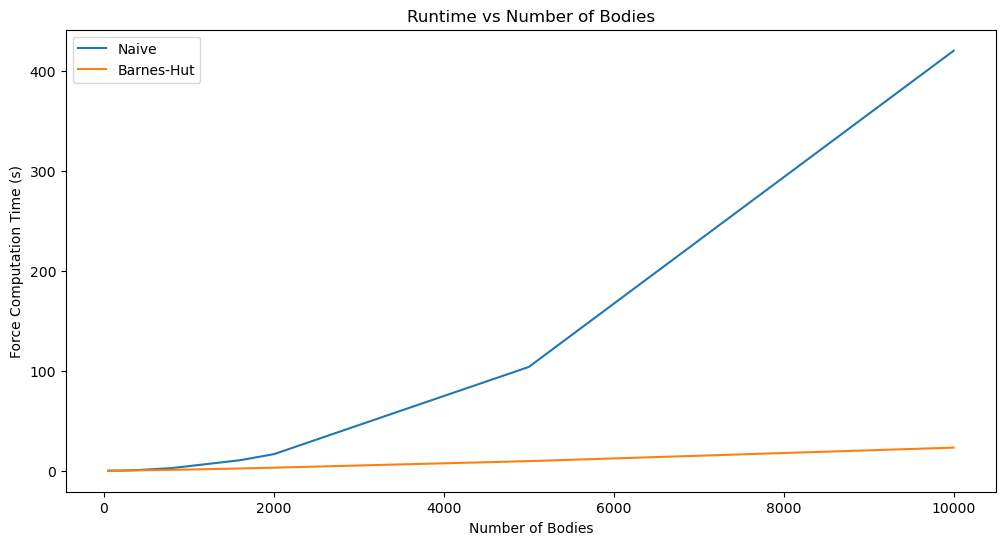

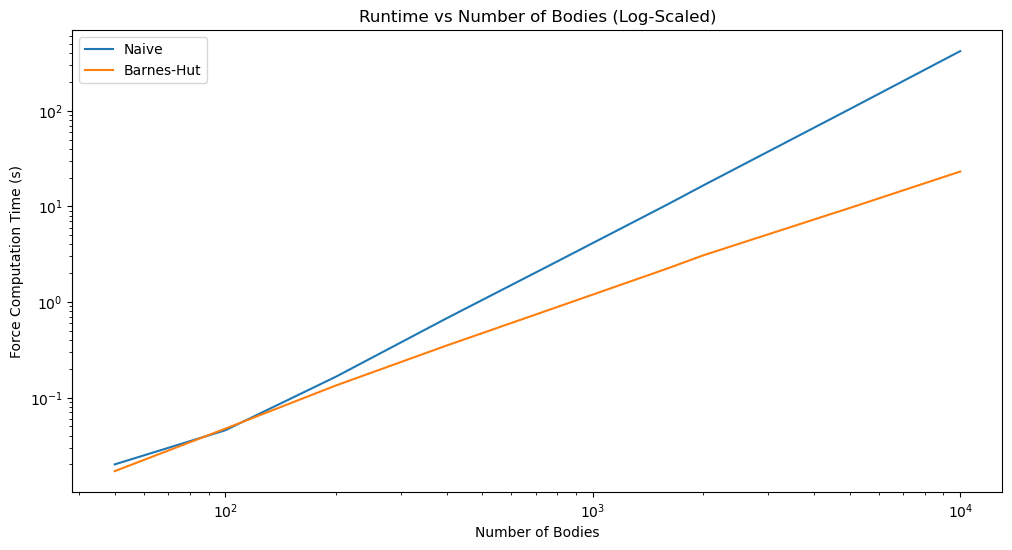

In [15]:
direct_time = []
BH_time = []
err = []

Ns = [50, 100, 200, 400, 800, 1600, 2000, 5000, 10000]
start_t = time()
positions = []
masses = []

for N in Ns:
    bodies = generate_random_bodies(N, seed=N)
    positions = [b.position for b in bodies]
    masses = [b.mass for b in bodies]
        
    t0 = time()
    F_exact = DirectForceCalculator.compute_accelerations(positions, masses)
    t1 = time()
    F_approx = BarnesHutForceCalculator.compute_accelerations(positions, masses)
    t2 = time()
    
    direct_time.append(t1 - t0)
    BH_time.append(t2 - t1)
    pct_error = np.abs(F_exact - F_approx) / np.abs(F_exact)
    err.append(np.sum(pct_error) / N)
end_t = time()

fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.plot(Ns, direct_time, label="Naive")
plt.plot(Ns, BH_time, label="Barnes-Hut")
plt.xlabel("Number of Bodies")
plt.ylabel("Force Computation Time (s)")
plt.title("Runtime vs Number of Bodies")
ax.legend()
plt.savefig("BH Runtime", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.loglog(Ns, direct_time, label="Naive")
plt.loglog(Ns, BH_time, label="Barnes-Hut")
plt.xlabel("Number of Bodies")
plt.ylabel("Force Computation Time (s)")
plt.title("Runtime vs Number of Bodies (Log-Scaled)")
ax.legend()
plt.savefig("BH Runtime (log scale)", dpi=300, bbox_inches="tight")
plt.show()

### Error vs $\theta$ Analysis

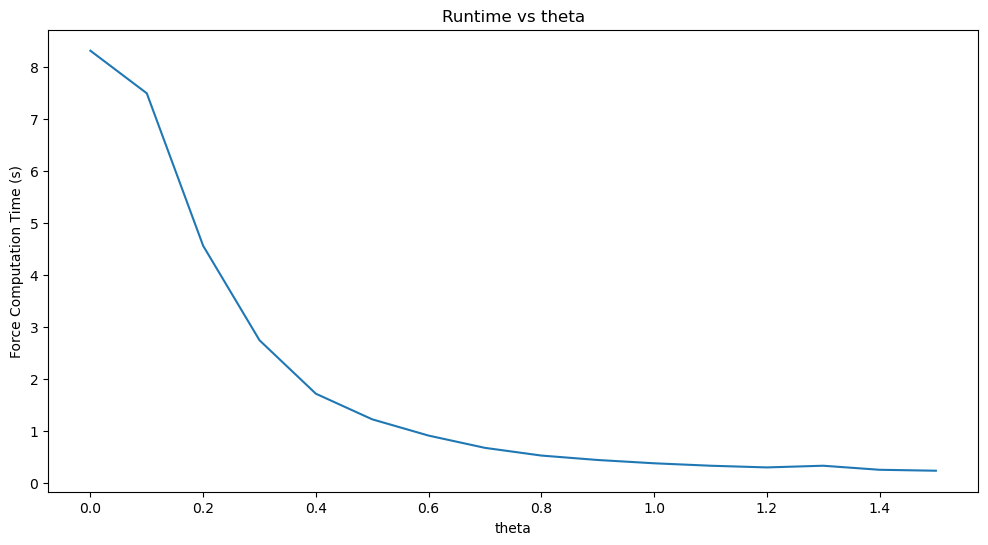

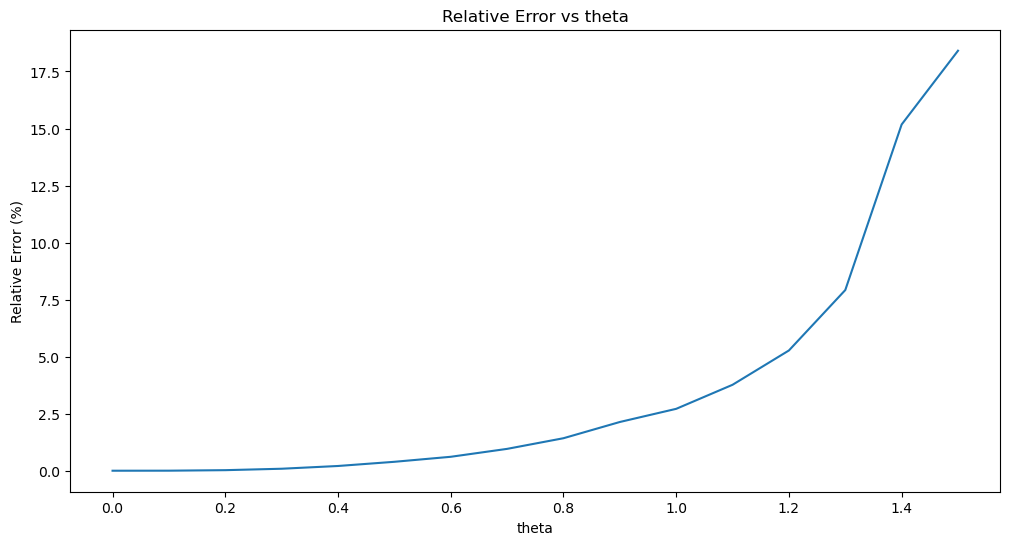

In [11]:
thetas = np.arange(0, 1.6, 0.1)
times = []
exact = None
errs = []

n = 1000
bodies = generate_random_bodies(n, seed=n)
positions = [b.position for b in bodies]
masses = [b.mass for b in bodies]

for theta in thetas:
    t1 = time()
    F_approx = BarnesHutForceCalculator.compute_accelerations(positions, masses, theta)
    t2 = time()
    times.append(t2 - t1)

    if theta == 0:
        exact = F_approx
    errs.append(np.linalg.norm(exact - F_approx)/np.linalg.norm(exact) * 100)
        
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.plot(thetas, times)
plt.xlabel("theta")
plt.ylabel("Force Computation Time (s)")
plt.title("Runtime vs theta")
plt.savefig("Runtime vs theta", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12,6))
plt.plot(thetas, errs)
plt.xlabel("theta")
plt.ylabel("Relative Error (%)")
plt.title("Relative Error vs theta")
plt.savefig("Error vs theta", dpi=300, bbox_inches="tight")
plt.show()